In [80]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from PIL import Image
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import numpy as np
import cv2 as cv
import torchlayers as tl
import os

In [8]:
import sys
import platform

print("ARCH:", platform.architecture())
print(torch.__version__)
print(torch.cuda.is_available())
torch.zeros(1).cuda()

ARCH: ('64bit', 'WindowsPE')
1.8.1
True


tensor([0.], device='cuda:0')

5141 4112 1029
Ssangyong


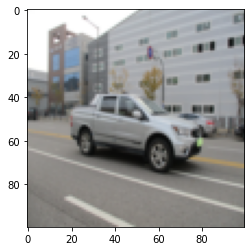

In [72]:
trans = transforms.Compose([transforms.Resize((100,100)), transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
datas = torchvision.datasets.ImageFolder(root = "./data/kcar", transform = trans)
labels = datas.classes

train_size = int(len(datas) * 0.8)
test_size = len(datas) - train_size
train_data, test_data = torch.utils.data.random_split(datas, [train_size, test_size])
img, label = test_data[0]
print(len(datas), len(train_data), len(test_data))
print(labels[label])
imshow(img)

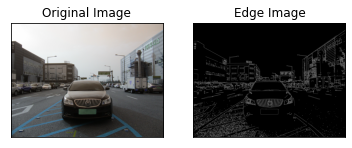

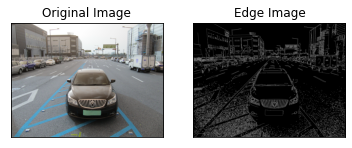

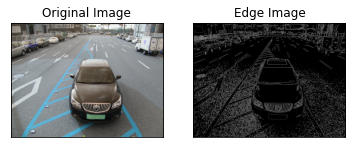

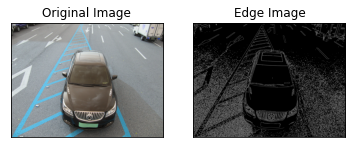

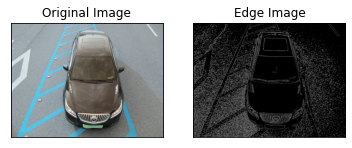

In [137]:
edges=[]
name = ["0", "15", "30", "45", "60"]
for n in name:
    path = ".\\data\\kcar\\GM Daewoo\\GM Daewoo\\GM Daewoo\\GM Daewoo\\알페온\\2011\\10시대\\H0\\GM대우_알페온_2011_10시대_H0_V"+n+".jpg"
    img_array = np.fromfile(path, np.uint8)
    im = cv.imdecode(img_array, cv.IMREAD_COLOR)
    edges.append(cv.Canny(im,100,200))
    plt.subplot(121),plt.imshow(im,cmap = 'gray')
    plt.title('Original Image'), plt.xticks([]), plt.yticks([])
    plt.subplot(122),plt.imshow(edges[-1],cmap = 'gray')
    plt.title('Edge Image'), plt.xticks([]), plt.yticks([])
    plt.show()

In [9]:
import matplotlib.pyplot as plt
from torchvision.transforms import ToPILImage

def imshow(img):
    img = img /2 + 0.5
    np_img = img.numpy()
    plt.imshow(np.transpose(np_img, (1,2,0)))
    # plt.show()


In [11]:
class CNN(tl.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = tl.Conv2d(64, kernel_size=6)
        self.conv2 = tl.Conv2d(128, kernel_size=3)
        self.conv3 = tl.Conv2d(256, kernel_size=3, padding=1)
        self.fc1 = tl.Linear(120)
        self.fc2 = tl.Linear(60)
        self.fc3 = tl.Linear(10)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.max_pool2d(x, kernel_size=2, stride=2)
        x = torch.relu(self.conv2(x))
        x = torch.max_pool2d(x, kernel_size=2, stride=2)

        x = x.view(-1, self.num_flat_features(x)) # [batch_size, 50, 4, 4]
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def num_flat_features(self, x):  
        size = x.size()[1:] 
        num_features = 1 
        for s in size: 
            num_features *= s 
        return num_features


In [59]:
train_loader = DataLoader(train_data, batch_size = 16, shuffle = True, num_workers = 4)
test_loader = DataLoader(test_data, batch_size = 16)

In [60]:
model1 = torch.nn.Sequential(
    tl.Conv(64),  # specify ONLY out_channels
    torch.nn.ReLU(),  # use torch.nn wherever you wish
    tl.BatchNorm(),  # BatchNormNd inferred from input
    tl.Conv(128),  # Default kernel_size equal to 3
    tl.ReLU(),
    # tl.Conv(256, kernel_size=11),  # "same" padding as default
    tl.GlobalMaxPool(),  # Known from Keras
    # tl.Linear(2),  # Output for 2 classes
)
model = tl.build(model1, torch.randn(1, 3, 28, 28))
model.cuda()

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): Conv2d(128, 256, kernel_size=(11, 11), stride=(1, 1), padding=(5, 5))
  (6): GlobalMaxPool()
  (7): Linear(in_features=256, out_features=2, bias=True)
)

In [49]:
vgg_model = torchvision.models.vgg16(pretrained=True)
# arbitrary
last_module = nn.Linear(100, 2, bias=True)
vgg_model.add_module('last_module', last_module)
# last_module.apply(user_defined_initialize_function)
vgg_model.cuda()
model = vgg_model

In [61]:
# model = CNN()
# cnn = tl.build(model.cuda(), torch.randn(1, 3, 32, 32))
# criterion = torch.nn.CrossEntropyLoss()

# set optimizer. model.parameter를 넘겨준다.
optimizer = optim.Adam(model.parameters(), lr=0.0001, betas=(0.5, 0.999))
# optimizer = optim.SGD(model.parameters(), lr=0.01)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f'{device} is available')
print(torch.cuda.is_available())
torch.cuda.empty_cache()
# print(torch.cuda.memory_summary(device=None, abbreviated=False))

cuda:0 is available
True
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 5            |        cudaMalloc retries: 6         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |    3446 MB |    4551 MB |    1287 GB |    1283 GB |
|       from large pool |    3437 MB |    4539 MB |    1283 GB |    1280 GB |
|       from small pool |       8 MB |      11 MB |       3 GB |       3 GB |
|---------------------------------------------------------------------------|
| Active memory         |    3446 MB |    4551 MB |    1287 GB |    1283 GB |
|       from large pool |    3437 MB | 

In [62]:
model.train()  # 학습
for epoch in range(1):
  for index, (data, target) in enumerate(train_loader):
    data, target = data.cuda(), target.cuda()
    optimizer.zero_grad()  # 기울기 초기화
    output = model(data)
    # output = output.cuda()
    loss = criterion(output, target)
    loss.backward()  # 역전파
    optimizer.step()

    if index % 10 == 0:
      print("loss of {} epoch, {} index : {}".format(epoch, index, loss.item()))

loss of 0 epoch, 0 index : 0.5641613006591797
loss of 0 epoch, 10 index : 0.3512078523635864


KeyboardInterrupt: 

In [48]:
model.eval()  # test
test_loss = 0
correct = 0
with torch.no_grad():
  for data, target in test_loader:
    data, target = data.cuda(), target.cuda()
    output = model(data)
    test_loss += criterion(output, target).item() # sum up batch loss
    pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))


Test set: Average loss: 9.6571, Accuracy: 966/1029 (94%)

